# Machine Learning project CS-433: NMR spectroscopy supervised learning



___

## Schedules:

* Week 10 (18-24 November): 
 * Tests of various linear models/simple NN on a 10% subset of data
* Week 11 (25-1 December):
 * Feature selection: being able to come with a good set of features
* Week 12 (2-8 December):
 * Start of big scale analysis with Spark, implementation of the models which perform well at small scale
* Week 13 (9-15 December):
 * Wrapping up
* Week 14 (16-22 December): 
 * 19th December: Deadline

___

## Table of contents

1. [Log Book](#log)
2. [Pipeline](#pipeline)
3. [Data Processing](#data_proc) <br>
&emsp;3.1. [Data Vizualisation](#data_viz) <br>
&emsp;3.2 [Outliers detection](#outliers) <br>
  &emsp;&emsp;3.2.1 [DBSCAN](#dbscan) <br>
  &emsp;&emsp;3.2.2 [Inter quantile range method](#iqr) <br>
&emsp;3.3 [Scaling](#scaling) <br>
&emsp;&emsp;3.3.1 [Min max scaling](#minmax) <br>
&emsp;3.4 [Dimensionality reduction](#dim_red) <br>
  &emsp;&emsp;3.4.1 [PCA](#pca) <br>
&emsp;3.5 [Feature Selection](#feat_sel) <br>
  &emsp;&emsp;3.5.1 [Relative importance from linear regression](#rel_imp_lin) <br>
  &emsp;&emsp;3.5.2 [Random forest](#rand_for) <br>
  &emsp;&emsp;3.5.3 [Univariate feature selection](#un_feat_sel) <br>
  &emsp;&emsp;3.5.4 [Recursive feature selection](#rec_feat_sel) <br>
  &emsp;&emsp;3.5.5 [Lasso Regression](#lasso) <br>
  &emsp;&emsp;3.5.6 [Boruta](#boruta) <br>
&emsp;3.6 [Models](#models) <br>
  &emsp;&emsp;3.6.1 [Linear Models](#lin_mods) <br>
  &emsp;&emsp;3.6.2 [Neural Networks](#NN) <br>
4. [Main](#main) <br>
   4.1 [ANN implementation](#ann_imp) <br>
    

In [1]:
import os
import re
import pickle
import scipy.stats
import sklearn.metrics
import datetime
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from itertools import combinations

from IPython.core.debugger import set_trace

from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

In [2]:
# For neural net part
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

#from keras.callbacks import ModelCheckpoint
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Flatten

___

## 1. Log Book
<a id='log'></a>


We write here the log of the different techniques/improvements we add to the program: **cf log/models_log.txt** for the different models already tested and their results.

___

## 2. Graph ideas
<a id='pipeline'></a>

In [ ]:
#pipeline graph coming soon

___

## 3. Data Exploration
<a id = 'data_proc'></a>

These are the cells you need to load to be able to work on the rest of the project:

In [7]:
#if set to true, all the functions call before the main will be effective
RUN = True

In [4]:
tot_data_X = np.load('data/CSD-10k_H_fps_1k_MD_n_12_l_9_rc_3.0_gw_0.3_rsr_1.0_rss_2.5_rse_5.npy',mmap_mode='r')
tot_data_y = np.load('data/CSD-10k_H_chemical_shieldings.npy',mmap_mode='r')
DATA_LEN = tot_data_X.shape[0]
DATA_COLS = tot_data_X.shape[1]

In [5]:
def load_data(n_samples,tot_data_x = tot_data_X,tot_data_y = tot_data_y):
    #np.random.seed(14)
    mask_data = np.random.permutation(DATA_LEN)[:n_samples]

    data_X = tot_data_X[mask_data]
    data_y = tot_data_y[mask_data]
    return data_X, data_y

In [6]:
def load_data_train_test(n_samples,tot_data_x = tot_data_X,tot_data_y = tot_data_y):
    data_X, data_y = load_data(n_samples,tot_data_x,tot_data_y)
    X_train,X_test,y_train,y_test = train_test_split(data_X,data_y,test_size = 0.2)
    return X_train,X_test,y_train,y_test

In [10]:
# Load the number of data you want for your code either to run fast/ be precise about the dataset
data_X,data_y = load_data(500)
data_X_df = pd.DataFrame(data_X)
data_y_df = pd.DataFrame(data_y)

### 3.1 Data Vizualisation
<a id='data_viz'></a>

In [11]:
def plot_distribs(X,feat_indxes = None):
    """
    X: pandas dataframe to plot the values for
    feat_indxes: columns you want to plot
    """
    if feat_indxes is None:
        feat_indxes = np.random.permutation(X.shape[1])[:9]
    else:
        assert(feat_indxes.shape[0] == 9)
    fig, axes = plt.subplots(nrows=3, ncols=3)
    fig.set_size_inches(11,11)
    for ind,i in enumerate(feat_indxes):
        index = np.unravel_index(ind,(3,3))
        axes[index].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
        X.iloc[:,i].hist(ax = axes[index],bins = 80)
        axes[index].title.set_text('col {}'.format(str(i)))
        #data_X_df.iloc[:,i].plot.box(ax = axes[index])

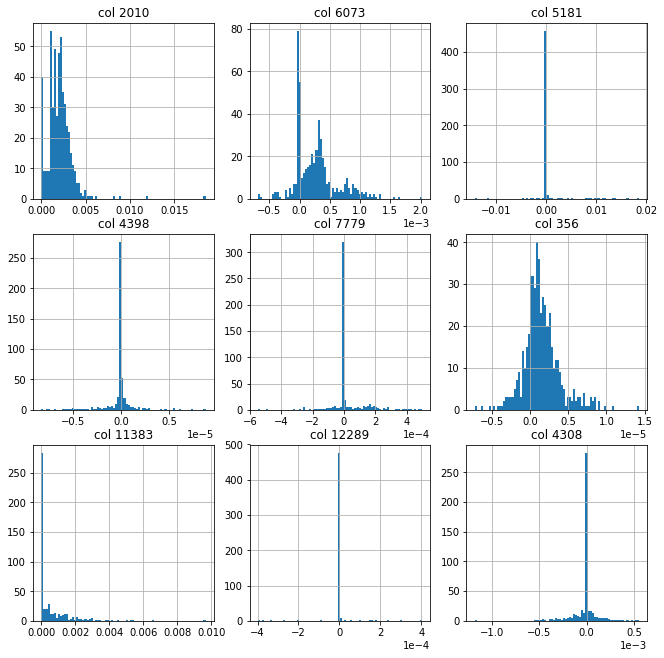

In [12]:
if RUN:
    plot_distribs(pd.DataFrame(data_X))

We see that the different features are scaled pretty differently, we might want to scale them beforehand. Since they don' look like following a gaussian, we'll apply min/max scaling: but in order to do so, we first need to get rid of the outliers thanks to one of the following methods
* Zscore: not adapted as our data might not be gaussian
* DBScan:
* Isolation Forest:

### 3.2 Outliers detection
<a id='outliers'></a>

#### 3.2.1 DBSCAN
<a id = 'dbscan'></a>

Problem: computationally too demanding.

#### 3.2.2 Interquartile range method (IQR)
<a id = 'iqr'></a>

Consists in considering as outliers all data points that lie in >1.5 interquartile range from the quartiles.

In [13]:
class IQR_outlier():
    def __init__(self, l_qtile= 5, h_qtile=95):
        self.l_qtile = l_qtile
        self.h_qtile = h_qtile
        
    def _reset(self):
        """Reset internal data-dependent state of the scaler, if necessary.
        __init__ parameters are not touched.
        """
        if (hasattr(self,'feat_qutiles')):
            del self.feat_qutiles
        
    def IQR(self,ys):
        """Compute the quartiles for a feature passed in argument
        """
        if self.l_qtile is None or self.h_qtile is None:
            raise ValueError("Quantiles not initialized")
            
        q1, q3 = np.percentile(ys, [self.l_qtile,self.h_qtile])
        iqr = q3 - q1
        lower_bound = q1 - (iqr * 1.5)
        upper_bound = q3 + (iqr * 1.5)
        return np.array([lower_bound,upper_bound])

    
    def fit(self, X, y=None):
        """ compute the quartiles used to remove outliers later on
        Parameters
        ----------
        X : {array-like}, shape [n_samples, n_features]
            The data used to compute the different features to erase
        """
        # Reset internal state before fitting
        self._reset()
        self.feat_qutiles = np.array([self.IQR(feat) for feat in X.T])
        return self

            
    def transform(self, X,y):
        """Perform standardization by centering and scaling
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data we want to take out the outliers of
        """
        if self.feat_qutiles is None:
            raise ValueError("Data not fitted yet.")
            
        masks_indces = []
        for feat,bounds in zip(X.T,self.feat_qutiles):
            masks_indces.append(np.where((feat < bounds[0]) | (feat > bounds[1])))
            
        #hstack reducs everything in one dimension
        mask_final = np.hstack(masks_indces)
        X_trans = np.delete(X,mask_final,axis = 0)
        y_trans = np.delete(y,mask_final,axis = 0)
        
        return X_trans,y_trans
    
    def fit_transform(self,X,y):
        """fit X and transform X and y accordingly"""
        self.fit(X)
        return self.transform(X,y)

The following plots are meant to show whether or not a given outlier detection method is efficient.

<div class="alert alert-block alert-info">
Why not apply fit_transform method from the IQR_outlier class? instead of apply fit than transform?

<Figure size 432x288 with 0 Axes>

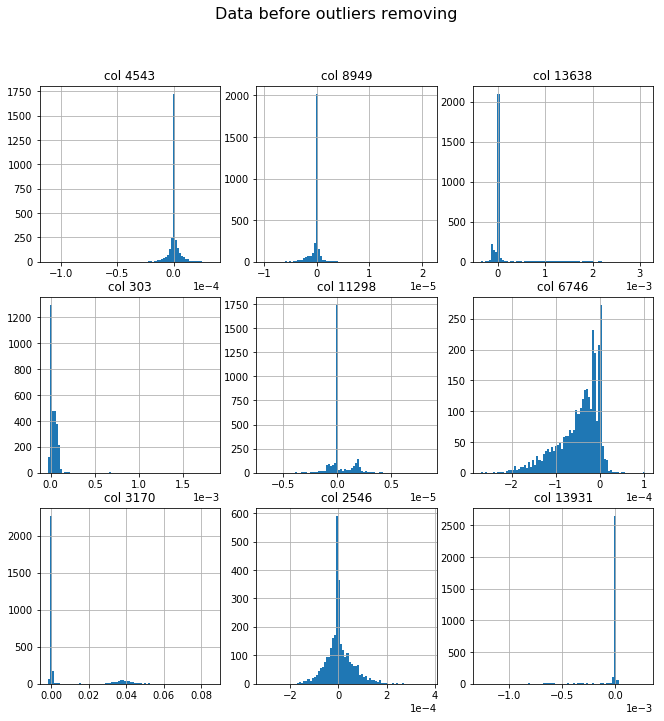

<Figure size 432x288 with 0 Axes>

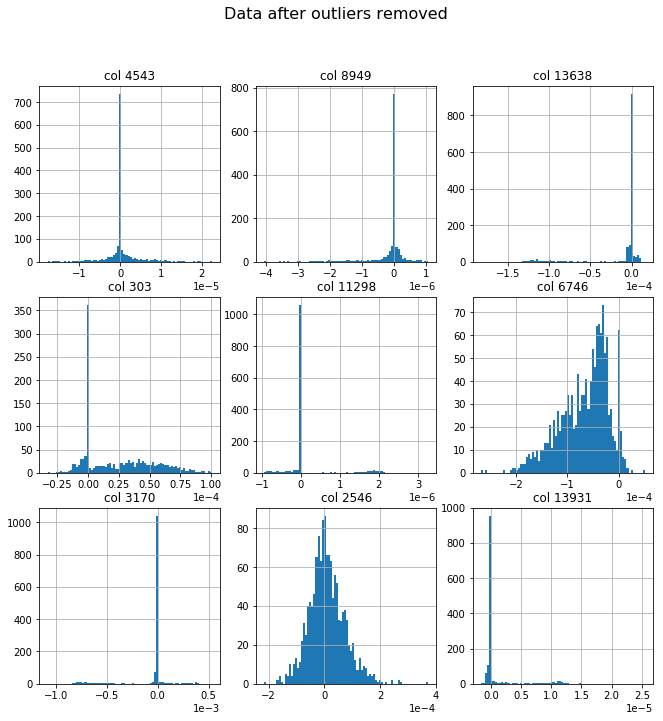

In [14]:
if RUN:
    data_X,data_y = load_data(3000)
    feat_indxes = np.random.permutation(data_X.shape[1])[:9]
    plt.figure()
    plot_distribs(pd.DataFrame(data_X),feat_indxes)
    plt.suptitle('Data before outliers removing', fontsize=16)
    
    out_det = IQR_outlier()
    out_det.fit(data_X)
    data_X_filt,data_y_filt = out_det.transform(data_X,data_y)
    plt.figure()
    plot_distribs(pd.DataFrame(data_X_filt),feat_indxes)
    plt.suptitle('Data after outliers removed', fontsize=16)

We conclude from these plots that a lot of the values situated in the "peaks" in the center are in fact outliers according to some feature. Some of the other features could potentially be visually seem to follow a gaussian distribution.

### 3.3 Scaling
<a id='scaling'></a>

#### 3.3.1 Min/max Scaling
<a id='minmax'></a>

Minmax scaling seems as an appropriate way to scale our data only if an outlier removing method is applied beforehand.

In [ ]:
def apply_scaler(scaler,X_train,X_test):
    """
    Function to scale outside of the pipeline
    """
    X_train = minmx_scaler.fit_transform(X_train)
    X_test = minmx_scaler.transform(X_test)
    return X_train,X_test

<div class="alert alert-block alert-info">
Shouldn't it be 'scaler' instead of 'minmx_scaler' in the method above?

#### 3.3.2 Robust Scaling

### 3.4 Dimensionality reduction
<a id='dim_red'></a>

#### 3.4.1 PCA
<a id = 'pca'></a>

We see that approximately 50 components are enough to explain more than 95% of the variance ==> we choose this value for most of the data.

In [ ]:
def plot_PCA(n_comp,X_train):
    """
    displays the 'elbow' of the PCA, ie the screeplot"""
    pca = PCA(n_components = n_comp)
    pca.fit(X_train)
    plt.figure(1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()
    
if RUN:    
    X_train,_,_,_ = load_data_train_test(3000)
    plot_PCA(70,X_train)

In [ ]:
def do_PCA(X_train,X_test,n):
    """
    Useful method to reduce train/test sets outside of the pipeline
    """
    pca = PCA(n_components = n)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return X_train,X_test

### 3.5 Feature Selection
<a id='feat_sel'></a>

#### 3.5.2 Random Forest
<a id='rand_for'></a>

<div class="alert alert-block alert-info">
    
Optimize the parameters of the random forest?

In [ ]:
#takes a while to run ==> pca first
if RUN:
    """
    forest = RandomForestRegressor(max_depth=4, random_state=0,n_estimators=100)
    forest.fit(data_X, data_y)
    w_forest = forest.feature_importances_
    """



#### 3.5.3 Univariate feature selection
<a id='un_feat_sel'></a>

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
def univ_feat_sel(X,y,keep = 0.2):
    """
    Plot feature selection using the f_regression from skleanr: 
    it computes an F score based on the correlation of the feature and 
    compute a pvalue based on that.
    X: data
    y: label
    keep: ratio of initial features you want to keep 
    """
    k = int(keep * X.shape[1])
    model = SelectKBest(score_func=f_regression, k=k)
    fit = model.fit(X, y)
    feature_ord_univ = np.argsort(fit.scores_)
    plt.bar(feature_ord_univ,fit.scores_)
if RUN:
    data_X,data_y = load_data(1000)
    univ_feat_sel(data_X,data_y)

As we can see, the importance varies a lot among features: the method seems appropriate to do feature selection as we can see in the following cells.

#### 3.5.4 Recursive feature selection
<a id='rec_feat_sel'></a>

In [ ]:
#almost impossible without a pca ==> pca first
if RUN:
    data_X,data_y = load_data(800)
    data_X,_ = do_PCA(data_X,np.zeros_like(data_X),120)
    ridge = Ridge(alpha = 0.005)
    rfe = RFE(ridge, 3)
    if RUN:
        fit = rfe.fit(data_X,data_y)
        print("Num Features: %d" % fit.n_features_)
        print("Selected Features: %s" % fit.support_)
        print("Feature Ranking: %s" % fit.ranking_)
    

We see that it is not the first components that are the most important weirdly.

#### 3.5.6 Boruta
<a id='boruta'></a>

In [ ]:
#https://www.datacamp.com/community/tutorials/feature-selection-R-boruta#boruta
from boruta import BorutaPy

def boruta_selection(X, y, keep = 0.2, max_depth=4, n_estimators = 100, random_state = None):
    """
    Feature selection with the Boruta algorithm. Finds all features carrying information usable for 
    prediction by shuffling the data in each feature and comparing its predictive power with the original
    feature. Only variables for whose importance is higher than that of the randomised variables are considered important.
    For more details check the following: https://github.com/scikit-learn-contrib/boruta_py
    
    X:            data
    y:            label
    keep:         ratio of initial features you want to keep 
    max_depth:    maximum depth for the trees in the random forest called
    n_estimators: number of trees in the forest
    random_state: seed for random processes
    
    output: 
    X_filtered: data composed of the selected features only
    """
    k = int(keep * X.shape[1])
    feat_indxes = np.random.permutation(X.shape[1])[:k]
    X = X[:,feat_indxes] # subsample the features just to reduce computational time for testing the algorithm
    
    # define random forest classifier, with utilising all cores and
    # sampling in proportion to y labels
    forest = RandomForestRegressor(max_depth = max_depth, random_state = random_state, n_estimators = n_estimators)
    #forest.fit(data_X, data_y)
    #w_forest = forest.feature_importances_

    # define Boruta feature selection method
    feat_selector = BorutaPy(forest, n_estimators='auto', verbose=0, random_state=1)

    # find all relevant features - 5 features should be selected
    feat_selector.fit(X, y)

    # check selected features - first 5 features are selected
    feat_selector.support_

    # check ranking of features
    feat_selector.ranking_

    # call transform() on X to filter it down to selected features
    X_filtered = feat_selector.transform(X)
    
    return X_filtered

In [ ]:
X_filtered = boruta_selection(X, y, keep = 0.001, max_depth=4, n_estimators=10)

### 3.6 Models
<a id='models'></a>

#### 3.6.1 Linear Models
<a id='lin_mods'></a>

In [ ]:
def test_alphas_meth(meth,alphas,X,y,k = 4):
    """
    Test the different values of alpha for a given method and return the best alpha according to the mse criterion.
    """
    res_mse = []
    for alpha in alphas: 
        rid = meth(alpha = alpha)
        res_mse.append(-cross_val_score(rid,X,y,cv = k,scoring='neg_mean_squared_error').mean())
    plt.semilogx(alphas,res_mse)
    plt.ylabel('Mse')
    plt.xlabel('lambdas')
    return alphas[np.argmin(res_mse)]

##### 3.6.1.1 Lasso Regression
<a id='lasso'></a>

In [ ]:
#lasso: with pca40:      0.01
#lasso: no pca    :      0.007
if RUN:
    data_X,data_y = load_data(3000)
    
    out = IQR_outlier()
    min_max = MinMaxScaler()
    pca = PCA(n_components=80)
    data_X,data_y = out.fit_transform(data_X,data_y)
    pipeline = Pipeline([('min_max', min_max), ('pca', pca)])
    data_X = pipeline.fit_transform(data_X)
    
    interv = np.logspace(np.log10(0.001),np.log10(10000),25)
    alph_opt = test_alphas_meth(Lasso,interv,data_X,data_y)
    print(alph_opt)

##### 3.6.1.2 Ridge Regression
<a id='lasso'></a>

With PCA

In [ ]:
if RUN:
    
    #ridge: with pca40:      0.006
    #ridge: no pca    :      0.002
    data_X,data_y = load_data(3000)
    
    out = IQR_outlier()
    min_max = MinMaxScaler()
    pca = PCA(n_components=80)
    data_X,data_y = out.fit_transform(data_X,data_y)
    pipeline = Pipeline([('min_max', min_max), ('pca', pca)])
    data_X = pipeline.fit_transform(data_X)
    
    interv = np.logspace(np.log10(0.001),np.log10(10000),25)
    alph_opt = test_alphas_meth(Ridge,interv,data_X,data_y)
    print(alph_opt)

With Boruta

In [ ]:
if RUN: 
    
    data_X,data_y = load_data(1000)
    
    out = IQR_outlier()
    data_X,data_y = out.fit_transform(data_X,data_y)
    
    min_max = MinMaxScaler()
    data_X = min_max.fit_transform(data_X)
    
    #boruta = BorutaPy(RandomForestRegressor)
    #data_X,data_y = boruta.fit_transform(data_X,data_y)
    
    data_X = boruta_selection(data_X,data_y, 0.001)
    
    interv = np.logspace(np.log10(0.001),np.log10(10000),25)
    alph_opt = test_alphas_meth(Ridge,interv,data_X,data_y)
    


##### 3.6.1.3 Elastic Net
<a id='lasso'></a>

In [ ]:
#elasticnet: with pca40:      0.006
#elasticnet: no pca    :      0.002
if RUN:
    data_X,data_y = load_data(3000)
    
    out = IQR_outlier()
    min_max = MinMaxScaler()
    pca = PCA(n_components=80)
    data_X,data_y = out.fit_transform(data_X,data_y)
    pipeline = Pipeline([('min_max', min_max), ('pca', pca)])
    data_X = pipeline.fit_transform(data_X)
    
    interv = np.logspace(np.log10(0.001),np.log10(10000),25)
    alph_opt = test_alphas_meth(ElasticNet,interv,data_X,data_y)
    print(alph_opt)

#### 3.5.2 Neural Nets

<a id='NN'></a>

In [ ]:
class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n,100)
        #self.fc2 = nn.Linear(80,50)
        #self.fc3 = nn.Linear(624,624)
        self.fc4 = nn.Linear(100,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [ ]:
def train_model(model, train_input, train_target, mini_batch_size, monitor_loss=False):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-3) 
    nb_epochs = 100
    
    # Monitor loss
    losses = []
    
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            
            sum_loss += loss.item() # compute loss for each mini batch for 1 epoch
            
            optimizer.step()
        
        # Monitor loss
        losses.append(sum_loss)
        
        print('[epoch {:d}] loss: {:0.2f}'.format(e+1, sum_loss))
    
    if monitor_loss:
        return losses

In [ ]:
def make_pred(model, data_input):
    y_hat = model(data_input)
    return y_hat

In [ ]:
def compute_score(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    print("Obtained MSE on test set %2.2f " % mse)
    print("Obtained MAE on test set %2.2f " % mae)
    return mse, mae

___

## 4. Main
<a id='main'></a>

### 4.0 Utility

In [15]:
def display_score(cv_results):
    """
    cv_results:dictionarry having
    test_neg_mean_squared_error,test_neg_mean_absolute_error and test_r2 as its key
    """
    K = len(cv_results['test_neg_mean_squared_error'])
    mse = -cv_results['test_neg_mean_squared_error'].mean()
    mae = -cv_results['test_neg_mean_absolute_error'].mean()
    r2 = cv_results['test_r2'].mean()
    print("On %i folds" % K)
    print("Obtained MSE on test set %2.2f " % mse)
    print("Obtained MAE on test set %2.2f " % mae)
    print("Obtained r2 on test set %2.2f " % r2)

In [16]:
def log_model(results,pipeline):
    """
    Write a log file of the model in order to keep trace of it
    """
    date = (datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    mse = -results['test_neg_mean_squared_error'].mean()
    mae = -results['test_neg_mean_absolute_error'].mean()
    r2 = results['test_r2'].mean()
    file_name = 'mae=%.2f_mse=%.2f_R2%.2f='%(mae,mse,r2) + date + '.txt'
    file_path = './log'
    
    res = {'mae':mae,'mse':mse,'r2':r2}
    
    pipeline = [str(i) for i in list(pipeline)]

    def defo(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        raise TypeError('Not serializable')
    with open('./log/' + file_name, 'w',encoding="utf-8",newline='\r\n') as file:
        json.dump(res,file,indent=4,ensure_ascii=False)
        json.dump(pipeline,file,default=defo)
    print('Log saved')
    

In [27]:
SCORING = ['neg_mean_squared_error', 'neg_mean_absolute_error','r2']

### 4.1 Pipelines

Each cell here is meant to do a whole pipeline, from loading a certain number of samples, preprocessing etc. We keep using the R2 score, the MSE and the MAE as our metrics.

In [ ]:
#Pipeline 1
data_X,data_y = load_data(10000)

out = IQR_outlier()
data_X,data_y = out.fit_transform(data_X,data_y)

pca = PCA()
min_max = MinMaxScaler()
rid = Ridge()
sel = SelectKBest(score_func=f_regression)
pipeline = Pipeline([
  ('min_max',min_max),
  ('feat_sel', sel),
  ('pca',pca),
  ('rid', rid)
])

param_grid = {
    'pca__n_components': [90,100,110],
    'rid__alpha': np.logspace(np.log10(0.1),np.log10(100),5),
    'feat_sel__k': [5000,6000],
}

cv = KFold(n_splits=5)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

#pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__estimator__alpha = bp_['feat_sel__estimator__alpha'])
pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__k = bp_['feat_sel__k'],rid__alpha = bp_['rid__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
log_model(results,pipeline)

In [ ]:
display_score(results)
print(search.best_estimator_.named_steps)

In [ ]:
#Pipeline 2

data_X,data_y = load_data(10000)

out = IQR_outlier()
data_X,data_y = out.fit_transform(data_X,data_y)

pca = PCA()
rob = RobustScaler()
rid = Ridge()
pipeline = Pipeline([
  ('rob',rob),
  ('pca',pca),
  ('rid', rid)
])

param_grid = {
    'pca__n_components': [60, 80, 100],
    'rid__alpha': np.logspace(np.log10(0.001),np.log10(1000),10)
   # 'feat_sel__estimator__alpha': np.logspace(np.log10(0.001),np.log10(1000), 5),
}

cv = KFold(n_splits=5)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

#pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__estimator__alpha = bp_['feat_sel__estimator__alpha'])
pipeline.set_params(pca__n_components= bp_['pca__n_components'],rid__alpha = bp_['rid__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
log_model(results,pipeline)
display_score(results)
print(search.best_estimator_.named_steps)

In [ ]:
#Pipeline 3
data_X,data_y = load_data(5000)

out = IQR_outlier()
data_X,data_y = out.fit_transform(data_X,data_y)

pca = KernelPCA(kernel = 'rbf',degree = 3)
min_max = MinMaxScaler()
rid = Ridge()
pipeline = Pipeline([
  ('min_max',min_max),
  ('pca',pca),
  ('ridge', rid)
])

param_grid = {
    'pca__n_components': [80, 100],
    'ridge__alpha': [10,30,50,100],
}

cv = KFold(n_splits=5)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

#pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__estimator__alpha = bp_['feat_sel__estimator__alpha'])
pipeline.set_params(pca__n_components= bp_['pca__n_components'],ridge__alpha = bp_['ridge__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
log_model(results,pipeline)
display_score(results)
print(search.best_estimator_.named_steps)

In [ ]:
#Pipeline 4

# TODO parameters grid still to define clearly for this pipeline
data_X,data_y = load_data(1000)

out = IQR_outlier()
data_X,data_y = out.fit_transform(data_X,data_y)
min_max = MinMaxScaler()
forest = RandomForestRegressor()
boruta = BorutaPy(forest)
rid = Ridge()
pipeline = Pipeline([
  ('min_max',min_max),
  ('boruta',boruta),
  ('ridge', rid)
])

param_grid = {
    #'pca__n_components': [80, 100],
    'ridge__alpha': [10,30,50,100],
}

cv = KFold(n_splits=5)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

#pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__estimator__alpha = bp_['feat_sel__estimator__alpha'])
pipeline.set_params(ridge__alpha = bp_['ridge__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
log_model(results,pipeline)
display_score(results)
print(search.best_estimator_.named_steps)

In [33]:
# Pipeline 5
# Load data
data_X, data_y = load_data(2000)
X_tr, X_te, y_tr, y_te = train_test_split(data_X, data_y, test_size = 0.2)

# Pre-process data (optional)
# ...

# Define pipeline
steps = [('scaler', MinMaxScaler()), ('elastic_net', ElasticNet( max_iter=2000))]
pipeline = Pipeline(steps)

# Define a parameter grid (use in gridsearch)
parameters = {
    'elastic_net__alpha': [0.1, 0.5, 0.75, 1.0], #don't use 0
    'elastic_net__l1_ratio': [0.1, 0.5, 0.75, 1.0] #don't use 0       
}

# Instantiate the gridsearch object
grid = GridSearchCV(pipeline, parameters, scoring = 'neg_mean_squared_error', cv=5) #scoring = 'neg_mean_absolute_error'

# Fit on training data
grid.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('elastic_net', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'elastic_net__alpha': [0.1, 0.5, 0.75, 1.0], 'elastic_net__l1_ratio': [0.1, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [34]:
print(grid.best_score_)
print(grid.best_params_)
#print(grid.best_estimator_)

-1.6405790472127055
{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.1}


In [35]:
print(grid.score(X_tr,y_tr))
print(grid.score(X_te,y_te))

-1.462606486752715
-2.447023505820839


In [37]:
pipeline.set_params(elastic_net__alpha= 0.1, elastic_net__l1_ratio = 0.1)

results = cross_validate(pipeline,data_X, data_y, cv = 5,scoring=SCORING)
display_score(results)

On 5 folds
Obtained MSE on test set 1.77 
Obtained MAE on test set 0.93 
Obtained r2 on test set 0.86 


#### 4.1.1 Assessing the complexity of the model
<a id='ass_cpx'></a>
 

Check whether our model is complex enough. That is, more data should lower the predictive error of the model. If not, our model is too simplistic and ANN implementation is justified. 

As such, compute the relation between size of data (scalability) and the prediction error for a given model for different scoring (mse, mae, r2). In practice, compute bias-variance decomposition.

In [ ]:
def pipeline1(size, seeds):
    """
    Pipeline 1 from above defined here as a function to call it in the function 'bias_variance'. 
    """
    results = []
    
    # Generate random data subsets of size 'size'
    for seed in seeds:
        
        print('Seed {s} \n'.format(s=seed))
        
        data_X,data_y = load_data(size, seed)
        out = IQR_outlier()
        data_X,data_y = out.fit_transform(data_X,data_y)

        pca = PCA()
        min_max = MinMaxScaler()
        rid = Ridge()
        sel = SelectKBest(score_func=f_regression)
        pipeline = Pipeline([
          ('min_max',min_max),
          ('feat_sel', sel),
          ('pca',pca),
          ('rid', rid)
        ])

        param_grid = {
            'pca__n_components': [90,100,110],
            'rid__alpha': np.logspace(np.log10(0.1),np.log10(100),5),
            'feat_sel__k': [5000,6000],
        }

        cv = KFold(n_splits=5)
        search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
        search.fit(data_X,data_y)

        best_score = search.best_score_
        bp_ = search.best_params_
        be_ = search.best_estimator_

        pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__k = bp_['feat_sel__k'],rid__alpha = bp_['rid__alpha'])

        results.append(cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING, return_train_score=True))
        
    return results

In [ ]:
def bias_variance_visualization(scoring_train, scoring_test, mean_scoring_train, mean_scoring_test, data_range, axis, scoring):
    """
    Visulize the bias-variance decomposition on 3 subplots, one for each scoring.
    """ 
    axis.plot(
        data_range,
        scoring_train,
        'b',
        linestyle="-",
        color=([0.7, 0.7, 1]),
        label='train',
        linewidth=0.3)
    axis.plot(
        data_range,
        scoring_test,
        'r',
        linestyle="-",
        color=[1, 0.7, 0.7],
        label='test',
        linewidth=0.3)
    axis.plot(
        data_range,
        mean_scoring_train,
        'b',
        linestyle="-",
        label='train',
        linewidth=3)
    axis.plot(
        data_range,
        mean_scoring_test,
        'r',
        linestyle="-",
        label='test',
        linewidth=3)
    axis.set_xlabel("data size")
    axis.set_ylabel("error")
    axis.set_title(scoring)
    #axis.legend(loc='best')

In [ ]:
def bias_variance_decomposition(data_range, results, seeds):
    """
    Decompose the results and triggers their visualization.
    """
    
    print("Start printing... \n")
    
    k = len(results[0][0]['fit_time'])
    mse_tr, mae_tr, r2_tr, mse_te, mae_te, r2_te = np.zeros((6, len(data_range), len(seeds), k))
    
    # Splitting the results into the different scorings and training and testing errors.
    for i, size in enumerate(data_range):
        for index, seed in enumerate(seeds):
            
            mse_tr[i][index] = -results[i][index]['train_neg_mean_squared_error']
            mse_te[i][index] = -results[i][index]['test_neg_mean_squared_error']
            
            mae_tr[i][index] = -results[i][index]['train_neg_mean_absolute_error']
            mae_te[i][index] = -results[i][index]['test_neg_mean_absolute_error']
            
            r2_tr[i][index] = results[i][index]['train_r2']
            r2_te[i][index] = results[i][index]['test_r2']
    
    # averaging the results over k-fold and then random seeds
    mse_tr_mean_kfold = mse_tr.mean(axis=2)
    mse_tr_mean_seeds = mse_tr_mean_kfold.mean(axis=1)
    mse_te_mean_kfold = mse_te.mean(axis=2)
    mse_te_mean_seeds = mse_te_mean_kfold.mean(axis=1)
    
    mae_tr_mean_kfold = mae_tr.mean(axis=2)
    mae_tr_mean_seeds = mae_tr_mean_kfold.mean(axis=1)
    mae_te_mean_kfold = mae_te.mean(axis=2)
    mae_te_mean_seeds = mae_te_mean_kfold.mean(axis=1)
    
    r2_tr_mean_kfold = r2_tr.mean(axis=2)
    r2_tr_mean_seeds = r2_tr_mean_kfold.mean(axis=1)
    r2_te_mean_kfold = r2_te.mean(axis=2)
    r2_te_mean_seeds = r2_te_mean_kfold.mean(axis=1)
    
    # Visualization
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    fig.set_size_inches(14,9)
    
    bias_variance_visualization(mse_tr_mean_kfold,mse_te_mean_kfold, mse_tr_mean_seeds, mse_te_mean_seeds, data_range, axes[0], 'mse')
    bias_variance_visualization(mae_tr_mean_kfold, mae_te_mean_kfold, mae_tr_mean_seeds, mae_te_mean_seeds,data_range, axes[1], 'mae')
    bias_variance_visualization(r2_tr_mean_kfold, r2_te_mean_kfold, r2_tr_mean_seeds, r2_te_mean_seeds, data_range, axes[2], 'r2')
    
    plt.savefig("bias-variance")
    
    return mse_tr_mean_seeds, mae_tr_mean_seeds, r2_tr_mean_seeds, mse_te_mean_seeds, mae_te_mean_seeds, r2_te_mean_seeds



In [ ]:
def bias_variance(pipeline, start, stop, number, seed_number):
    """
    Bias-variance decomposition to test the predictive power of a pipeline with subsets of different sizes.
    """
    data_range = np.logspace(np.log10(start),np.log10(stop),number, dtype=int)
    results = []
    
    seeds = range(seed_number)
    
    for iter_, size in enumerate(data_range):
        print('Data size of iteration {i}: {s} \n'.format(i=iter_, s=size))
        results.append(pipeline(size, seeds))
    
    print('Finished cross-validation...\n')
    
    return bias_variance_decomposition(data_range, results, seeds)

Testing pipeline 1 with 3 datasizes from 500 to 2000 (logscale), and 2 seeds.

In [ ]:
mse_tr, mae_tr, r2_tr, mse_te, mae_te, r2_te = bias_variance(pipeline1, 500, 2000, 3, 2)

#### 4.2 ANN implementation
<a id='ann_imp'></a>

In [ ]:
#Neural nets
#Get the data
X_train,X_test,y_train,y_test = load_data_train_test(10000)
X_train, X_test = do_PCA(X_train,X_test,40)
minmx_scaler = MinMaxScaler()
X_train, X_test = apply_scaler(minmx_scaler,X_train,X_test)

#Convert to tensors
train_input = torch.Tensor(X_train)
test_input = torch.Tensor(X_test)
train_target = torch.Tensor(y_train.reshape(len(y_train), 1))
test_target = torch.Tensor(y_test.reshape(len(y_test), 1))

In [ ]:
# Sanity check
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

In [ ]:
#Train model
mini_batch_size = 10
model = Net(40)
losses = train_model(model, train_input, train_target, mini_batch_size, monitor_loss=True)

In [ ]:
#Make predictions
y_hat = make_pred(model, test_input)

#Compute score
mse_nn, mae_nn = compute_score(y_test, y_hat.detach().numpy())

In [ ]:
plt.plot(np.arange(100)+1, losses)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss evolution during training', fontsize=15)

In [ ]:
plt.bar(np.arange(40)+1, rf.feature_importances_)
plt.xlabel('Feature number')
plt.ylabel('')
plt.title('Feature importance')

In [ ]:
# architecture 1
mlp_1 = Sequential()

mlp_1.add(Dense(100, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
mlp_1.add(Dense(1, kernel_initializer='normal',activation='linear'))

mlp_1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
mlp_1.summary()

In [ ]:
# architecture 2
mlp_2 = Sequential()

# The Input Layer
mlp_2.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers
mlp_2.add(Dense(256, kernel_initializer='normal',activation='relu'))
mlp_2.add(Dense(256, kernel_initializer='normal',activation='relu'))
mlp_2.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer
mlp_2.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network
mlp_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
mlp_2.summary()

In [ ]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
#callbacks_list = [checkpoint]

In [ ]:
ann_model = mlp_2
ann_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split = 0.2) #callbacks=callbacks_list)

In [ ]:
#Test model
y_hat = ann_model.predict(X_test)

#Compute score
mse_nn, mae_nn = compute_score(y_test, y_hat)

In [29]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']